# Load images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict
from torchvision import datasets, transforms, models

In [0]:
!rm -rf ./data

In [0]:
!tar -xvf "drive/My Drive/data.tar.gz" -C . > /dev/null

In [0]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'
using_gpu = torch.cuda.is_available()

In [0]:
# TODO: Build and train your network
epochs = 50
lr = 0.001
print_every = 20
batch_size = 64

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
testval_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
image_trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
image_testset = datasets.ImageFolder(test_dir, transform=testval_transforms)
image_valset = datasets.ImageFolder(valid_dir, transform=testval_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=64, shuffle=True)
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=64, shuffle=True)
image_valloader = torch.utils.data.DataLoader(image_valset, batch_size=64, shuffle=True)

In [0]:
# Freeze parameters so we don't backprop through them
hidden_layers = [10240, 1024]
def make_model(structure, hidden_layers, lr):
    model = models.densenet161(pretrained=True)
    input_size = 2208
    output_size = 3 # n_classes
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

In [0]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
      optimizer.zero_grad()
      inputs, labels = inputs.to('cuda') , labels.to('cuda')
      model.to('cuda')
      with torch.no_grad():    
          outputs = model.forward(inputs)
          validation_loss = criterion(outputs,labels)
          ps = torch.exp(outputs).data
          equality = (labels.data == ps.max(1)[1])
          accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

In [0]:
def my_DLM(model, image_trainloader, image_valloader, epochs, print_every):
    print_every = print_every
    steps = 0

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # change to cuda
    model.to('cuda')
    model.train()

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(image_trainloader):
            steps += 1

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                val_loss, train_ac = cal_accuracy(model, image_valloader)
                print("Epoch: {}/{}... | ".format(e+1, epochs),
                      "Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss {:.4f} | ".format(val_loss),
                      "Accuracy {:.4f}".format(train_ac))
                
                model.train()
                running_loss = 0
        save_model(e, model)

# Test model

In [0]:
def testing(model, dataloader):
    model.eval()
    model.to('cuda')
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in image_testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _ , prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels.data).sum().item()
        print('Accuracy on the test set: %d %%' % (100 * correct / total))   

# Save model

In [0]:
def save_model(epoch, model, save_dir='drive/My Drive'):
  state = {
    'structure' :'densenet161',
    'learning_rate': lr,
    'epochs': epochs,
    'hidden_layers':hidden_layers,
    'state_dict':model.state_dict(),
  }
  torch.save(state, f'{save_dir}/checkpoint_{epoch}.pth')

# Load model

In [0]:
def loading_checkpoint(path):
    
    # Loading the parameters
    state = torch.load(path)
    lr = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, lr)
    model.load_state_dict(state['state_dict'])
    return model

In [0]:
for i in range(epochs):
  model = loading_checkpoint(f'drive/My Drive/checkpoints/checkpoint_{i}.pth')
  testing(model, image_testloader)

Accuracy on the test set: 52 %
Accuracy on the test set: 61 %
Accuracy on the test set: 63 %
Accuracy on the test set: 65 %
Accuracy on the test set: 71 %
Accuracy on the test set: 71 %
Accuracy on the test set: 72 %
Accuracy on the test set: 71 %
Accuracy on the test set: 71 %
Accuracy on the test set: 71 %
Accuracy on the test set: 70 %
Accuracy on the test set: 69 %
Accuracy on the test set: 71 %
Accuracy on the test set: 73 %
Accuracy on the test set: 74 %
Accuracy on the test set: 74 %
Accuracy on the test set: 75 %
Accuracy on the test set: 76 %
Accuracy on the test set: 74 %
Accuracy on the test set: 74 %
Accuracy on the test set: 75 %
Accuracy on the test set: 76 %
Accuracy on the test set: 75 %
Accuracy on the test set: 76 %
Accuracy on the test set: 76 %
Accuracy on the test set: 77 %
Accuracy on the test set: 73 %
Accuracy on the test set: 75 %
Accuracy on the test set: 78 %
Accuracy on the test set: 77 %
Accuracy on the test set: 78 %
Accuracy on the test set: 78 %
Accuracy

# View results

In [0]:
def testing_images(model, image):
    model.eval()
    model.to('cuda')
    with torch.no_grad():
      image = image.to('cuda')
      label = model(image)
      _ , prediction = torch.max(label.data, 1)
      return prediction

In [41]:
model = loading_checkpoint(f'drive/My Drive/checkpoints/checkpoint_{49}.pth')
testing(model, image_testloader)

Accuracy on the test set: 80 %


In [42]:
image_trainloader.dataset.classes[0]

'ford'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

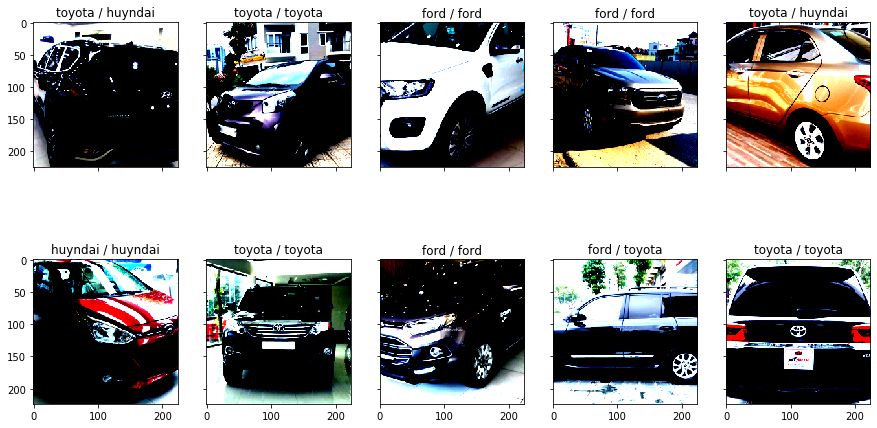

In [55]:
review_loader = torch.utils.data.DataLoader(image_testset, batch_size=10, shuffle=True)
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey='all', sharex='all', figsize=(15,8))
samples = next(iter(review_loader))
  
images, gt_labels = samples
predict_labels = testing_images(model, images).to('cpu').numpy()

images = [image.to('cpu').permute(1, 2, 0).numpy() for image in images]
gt_labels = [image_testloader.dataset.classes[label] for label in gt_labels]
predict_labels = [image_testloader.dataset.classes[label] for label in predict_labels]

for i, (image, predict_label, gt_label) in enumerate(zip(images, predict_labels, gt_labels)):
  title = f'{predict_label} / {gt_label}'
  axes[i // n_cols, i % n_cols].set_title(title)
  axes[i // n_cols, i % n_cols].imshow(image)

fig.savefig('./results.png', dpi=300)